## 1.数据集下载

In [1]:
# 文件处理相关
import os

# 华为云文件传输相关
import moxing

# 将数据包从OBS下载到ModelArts
print('输入数据路径（例：obs://桶名/目录/annotations.tar.gz）')
src = input('数据路径：')
moxing.file.copy_parallel(src_url=src, dst_url='annotations.tar.gz') # 下载数据

# 解压缩数据包
os.system('tar -zxvf annotations.tar.gz')

INFO:root:Using MoXing-v1.17.3.4-4b65c6b1
INFO:root:Using OBS-Python-SDK-3.20.9.1


输入数据路径（例：obs://桶名/目录/annotations.tar.gz）
数据路径：obs://fxy4/Unet/annotations.tar.gz


0

In [2]:
# 将数据包从OBS下载到ModelArts
print('输入数据路径（例：obs://桶名/目录/images.tar.gz）')
src = input('数据路径：')
moxing.file.copy_parallel(src_url=src, dst_url='images.tar.gz') # 下载数据

# 解压缩数据包
os.system('tar -zxvf images.tar.gz')

输入数据路径（例：obs://桶名/目录/images.tar.gz）
数据路径：obs://fxy4/Unet/images.tar.gz


0

## 2.数据集加载

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

/home/ma-user/anaconda3/envs/TensorFlow-2.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# 显存自适应分配
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
gpu_ok = tf.test.is_gpu_available()
print("tf version:", tf.__version__)
print("use GPU", gpu_ok) # 判断是否使用gpu进行训练

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


tf version: 2.1.0
use GPU True


In [6]:
 # 读取所有图片路径
images = glob.glob(r"images/*.jpg")
images.sort()
images[:5],len(images)

(['images/Abyssinian_1.jpg',
  'images/Abyssinian_10.jpg',
  'images/Abyssinian_100.jpg',
  'images/Abyssinian_101.jpg',
  'images/Abyssinian_102.jpg'],
 7390)

In [7]:
# 读取对应的目标图像
anno = glob.glob(r"annotations/trimaps/*.png")
anno.sort()
anno[:5],len(anno)

(['annotations/trimaps/Abyssinian_1.png',
  'annotations/trimaps/Abyssinian_10.png',
  'annotations/trimaps/Abyssinian_100.png',
  'annotations/trimaps/Abyssinian_101.png',
  'annotations/trimaps/Abyssinian_102.png'],
 7390)

## 3.数据预处理（归一化、随机裁剪、乱序）

In [8]:
np.random.seed(2021)
index = np.random.permutation(len(images)) # 创建一个随即种子，保障image和label 随机后还是一一对应的

In [9]:
images = np.array(images)[index] # 对训练集图片进行乱序
anno = np.array(anno)[index]

In [10]:
images[3:],anno[3:]

(array(['images/keeshond_81.jpg', 'images/leonberger_4.jpg',
        'images/english_setter_96.jpg', ..., 'images/samoyed_10.jpg',
        'images/chihuahua_110.jpg', 'images/Egyptian_Mau_40.jpg'],
       dtype='<U41'), array(['annotations/trimaps/keeshond_81.png',
        'annotations/trimaps/leonberger_4.png',
        'annotations/trimaps/english_setter_96.png', ...,
        'annotations/trimaps/samoyed_10.png',
        'annotations/trimaps/chihuahua_110.png',
        'annotations/trimaps/Egyptian_Mau_40.png'], dtype='<U54'))

In [11]:
# 创建数据集
dataset = tf.data.Dataset.from_tensor_slices((images,anno))

In [12]:
# 划分数据集
test_count = int(len(images)*0.2)
train_count = len(images)-test_count
test_count,train_count

(1478, 5912)

In [13]:
# 分割数据集
data_train =dataset.skip(test_count) # 跳过test_count 的数据作为训练数据
data_test = dataset.take(test_count) #  取出test_count的数据作为测试集

In [14]:
# 创建 jpg格式的解码函数
def read_jpg(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    return img

In [15]:
# 创建png的解码函数
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img,channels=1)
    return img

In [16]:
#  归一化
def normal_img(image,anno):
    image = tf.cast(image,tf.float32) # 改变数据类型为float32
    image = image/127.5 - 1  # 归一化到 -1 到 1 之间
    
    anno -= 1  # 因为目标图像取值范围是 1，2，3   我们 -1 修改为 0，1，2
    return image,anno

In [17]:
# 数据增强，随即裁剪
def crop_img(input_image,input_anno):
    concat_img = tf.concat([input_image,input_anno],axis=-1)
    concat_img = tf.image.resize(concat_img,(280,280), # 修改大小为280*280
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)#使用最近邻插值调整images为size
    crop_img = tf.image.random_crop(concat_img,[256,256,4]) # 随机裁剪
    return crop_img[ :, :, :3],crop_img[ :, :, 3:] # 高维切片(第一，第二维度全要，第三个维度的前3是image，最后一个维度就是label)

In [18]:
# 加载训练集函数
def load_images_train(input_images_path,input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    
    img,anno = crop_img(input_image,input_anno)
    
    if tf.random.uniform(())>0.5: # 从均匀分布中返回随机值 如果大于0.5就执行下面的随机翻转
        img = tf.image.flip_left_right(img)
        anno = tf.image.flip_left_right(anno)
    img,anno = normal_img(img,anno) # 调用归一化函数
    
    return img,anno

In [19]:
# 加载测试集函数
def load_images_test(input_images_path,input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    
    input_image = tf.image.resize(input_image,(256,256))
    input_anno = tf.image.resize(input_anno,(256,256))
    
    input_image,input_anno = normal_img(input_image,input_anno)
    
    return input_image,input_anno

In [20]:
# 使用训练集加载函数
data_train = data_train.map(load_images_train,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [21]:
# 使用测试集加载函数
data_test = data_test.map(load_images_test,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [22]:
BATCH_SIZE = 16
BUFFER_SIZE = 300
step_per_epoch = train_count//BATCH_SIZE
val_step = test_count//BATCH_SIZE

In [23]:
auto = tf.data.experimental.AUTOTUNE # 根据cpu使用情况自动规划线程读取图片

In [24]:
# 对数据集进行乱序
data_train = data_train.repeat().shuffle(5912).batch(BATCH_SIZE)
data_test = data_test.batch(BATCH_SIZE)

In [25]:
data_train,data_test

(<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>,
 <BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>)

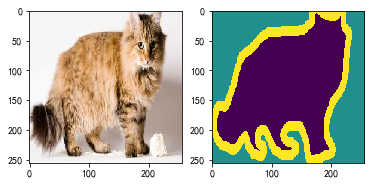

In [24]:
for image,mask in data_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((image[0].numpy()+1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(mask[0].numpy()))

## 4.Unet网络创建

In [26]:
def create_model():
    ## unet网络结构下采样部分
    # 输入层 第一部分
    inputs = tf.keras.layers.Input(shape = (256,256,3))
    
    x = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)  #  256*256*64
    # 下采样
    x1 = tf.keras.layers.MaxPooling2D(padding="same")(x) # 128*128*64
    
    # 卷积 第二部分
    x1 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)  #  128*128*128
    # 下采样 
    x2 = tf.keras.layers.MaxPooling2D(padding="same")(x1) # 64*64*128
        
    # 卷积 第三部分
    x2 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)  #  64*64*256
    # 下采样
    x3 = tf.keras.layers.MaxPooling2D(padding="same")(x2) # 32*32*256
    
    # 卷积 第四部分
    x3 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)
    x3 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)  #  32*32*512
    # 下采样
    x4 = tf.keras.layers.MaxPooling2D(padding="same")(x3) # 16*16*512
    # 卷积  第五部分
    x4 = tf.keras.layers.Conv2D(1024,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)
    x4 = tf.keras.layers.Conv2D(1024,3,padding="same",activation="relu")(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)  #  16*16*1024
    
    ## unet网络结构上采样部分
    
    # 反卷积 第一部分      512个卷积核 卷积核大小2*2 跨度2 填充方式same 激活relu
    x5 = tf.keras.layers.Conv2DTranspose(512,2,strides=2,
                                         padding="same",
                                         activation="relu")(x4)#32*32*512
    x5 = tf.keras.layers.BatchNormalization()(x5)
    x6 = tf.concat([x3,x5],axis=-1)#合并 32*32*1024
    # 卷积
    x6 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)
    x6 = tf.keras.layers.Conv2D(512,3,padding="same",activation="relu")(x6)
    x6 = tf.keras.layers.BatchNormalization()(x6)  #  32*32*512
    
    # 反卷积 第二部分
    x7 = tf.keras.layers.Conv2DTranspose(256,2,strides=2,
                                         padding="same",
                                         activation="relu")(x6)#64*64*256
    x7 = tf.keras.layers.BatchNormalization()(x7)
    x8 = tf.concat([x2,x7],axis=-1)#合并 64*64*512
    # 卷积
    x8 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)
    x8 = tf.keras.layers.Conv2D(256,3,padding="same",activation="relu")(x8)
    x8 = tf.keras.layers.BatchNormalization()(x8)  #  #64*64*256
    
    # 反卷积 第三部分
    x9 = tf.keras.layers.Conv2DTranspose(128,2,strides=2,
                                         padding="same",
                                         activation="relu")(x8)# 128*128*128
    x9 = tf.keras.layers.BatchNormalization()(x9)
    x10 = tf.concat([x1,x9],axis=-1)#合并 128*128*256
    # 卷积
    x10 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)
    x10 = tf.keras.layers.Conv2D(128,3,padding="same",activation="relu")(x10)
    x10 = tf.keras.layers.BatchNormalization()(x10)  # 128*128*128
    
    # 反卷积 第四部分
    x11 = tf.keras.layers.Conv2DTranspose(64,2,strides=2,
                                         padding="same",
                                         activation="relu")(x10)#  256*256*64
    x11 = tf.keras.layers.BatchNormalization()(x11)
    x12 = tf.concat([x,x11],axis=-1)#合并 256*256*128
    # 卷积
    x12 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)
    x12 = tf.keras.layers.Conv2D(64,3,padding="same",activation="relu")(x12)
    x12 = tf.keras.layers.BatchNormalization()(x12)  # 256*256*64
    
    # 输出层 第五部分
    output =tf.keras.layers.Conv2D(34,1,padding="same",activation="softmax")(x12)# 256*256*34
    
    return tf.keras.Model(inputs=inputs,outputs=output)
    

In [27]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

## 5.交叉验证

In [35]:
model1 = create_model()
model2 = create_model()
model3 = create_model()
models = [model1,model2,model3]
# 编译模型
for i in range(len(models)):
    models[i].compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["acc",MeanIou(num_classes=34)]
                 )
historys = []
for epoch in range(3):
    print("------------------------{}折验证-----------------------------".format(epoch+1))
    dataset = dataset.shuffle(5912)
    # 分割数据集
    train =dataset.skip(1478) # 跳过test_count 的数据作为训练数据
    val = dataset.take(test_count) #  取出test_count的数据作为测试集

    # 使用加载函数
    train = train.map(load_images_train,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val = val.map(load_images_test,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # 对数据集进行乱序
    train = train.repeat().shuffle(4434).batch(BATCH_SIZE)
    val = val.batch(BATCH_SIZE)
    
    history = models[i].fit(train,
              epochs=5,
              steps_per_epoch=train_count//BATCH_SIZE,
              validation_data=val,
              validation_steps=test_count//BATCH_SIZE,
    )
    historys.append(history)

In [39]:
accs = []
for i in range(len(historys)):
    acc = historys.history["acc"]
    accs.append(acc)
plt.boxplot((accs[0],accs[1],accs[2]),labels=('1','2','3'))
plt.show()

## 6.训练

In [28]:
# tf.keras.metrics.MeanIoU(num_classes=34) # 根据独热编码进行计算
# 我们是顺序编码 需要更改类
class MeanIou(tf.keras.metrics.MeanIoU): # 继承这个类 
    def __call__(self,y_true,y_pred,sample_weight=None): 
        y_pred = tf.argmax(y_pred,axis=-1) 
        return super().__call__(y_true,y_pred,sample_weight=sample_weight)
model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["acc",MeanIou(num_classes=34)]
                 )

In [29]:
# 训练
history = model.fit(data_train,
                    epochs=10,
                    steps_per_epoch=step_per_epoch,
                    validation_data=data_test,
                    validation_steps=val_step)

Train for 369 steps, validate for 92 steps
Epoch 1/10
369/369 [==============================] - 212s 573ms/step - loss: 1.2292 - acc: 0.6791 - mean_iou: 0.0364 - val_loss: 1.7643 - val_acc: 0.6132 - val_mean_iou: 0.0536
Epoch 2/10
369/369 [==============================] - 182s 493ms/step - loss: 0.6172 - acc: 0.7614 - mean_iou: 0.3111 - val_loss: 0.6371 - val_acc: 0.7651 - val_mean_iou: 0.5300
Epoch 3/10
369/369 [==============================] - 183s 495ms/step - loss: 0.5103 - acc: 0.8008 - mean_iou: 0.5811 - val_loss: 0.6020 - val_acc: 0.7880 - val_mean_iou: 0.1033
Epoch 4/10
369/369 [==============================] - 182s 494ms/step - loss: 0.4458 - acc: 0.8252 - mean_iou: 0.6207 - val_loss: 0.4285 - val_acc: 0.8371 - val_mean_iou: 0.6384
Epoch 5/10
369/369 [==============================] - 182s 492ms/step - loss: 0.4081 - acc: 0.8410 - mean_iou: 0.6460 - val_loss: 0.4623 - val_acc: 0.8039 - val_mean_iou: 0.1637
Epoch 6/10
369/369 [==============================] - 182s 493ms/st

## 7.评价指标

### 7.1  loss曲线

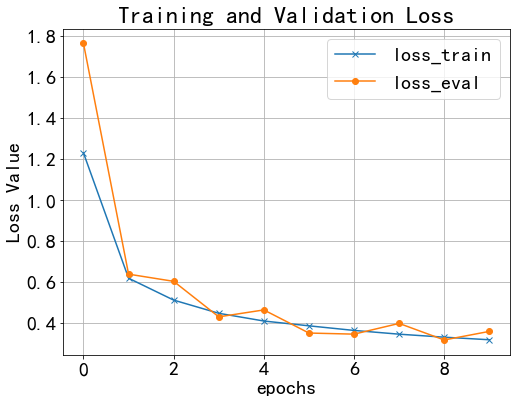

In [30]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(10)
plt.rcParams.update({"font.size":20})
plt.figure(figsize=(8,6))
plt.plot(loss,marker='x',label="Trainning loss")
plt.plot(val_loss,marker='o',label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("epochs")
plt.ylabel("Loss Value")
plt.grid()
plt.legend(['loss_train', 'loss_eval'], loc='upper right')
plt.show()

### 7.2 准确率曲线

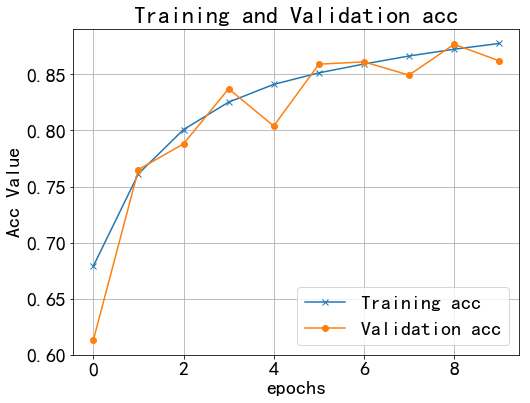

In [31]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
plt.figure(figsize=(8,6))
plt.plot(acc,marker='x',label="Training acc")
plt.plot(val_acc,marker='o',label="Validation acc")
plt.title("Training and Validation acc")
plt.xlabel("epochs")
plt.ylabel("Acc Value")
plt.grid()
plt.legend()
plt.show()

### 7.3 平均IoU曲线

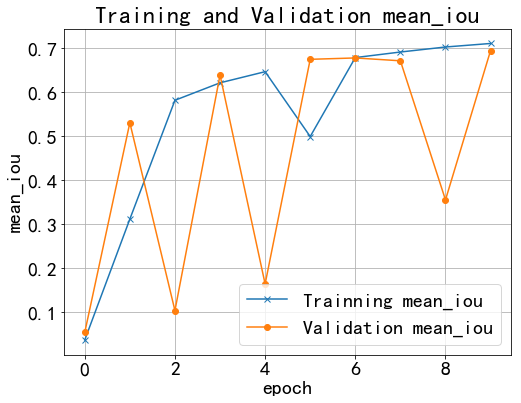

In [32]:
meanIoU = history.history["mean_iou"]
val_meanIoU = history.history["val_mean_iou"]

plt.figure(figsize=(8,6))
plt.plot(meanIoU,marker='x',label="Trainning mean_iou")
plt.plot(val_meanIoU,marker='o',label="Validation mean_iou")
plt.title("Training and Validation mean_iou")
plt.xlabel("epoch")
plt.ylabel("mean_iou")
plt.grid()
plt.legend()
plt.show()

## 8.可视化预测结果

### 8.1测试数据集中的测试集

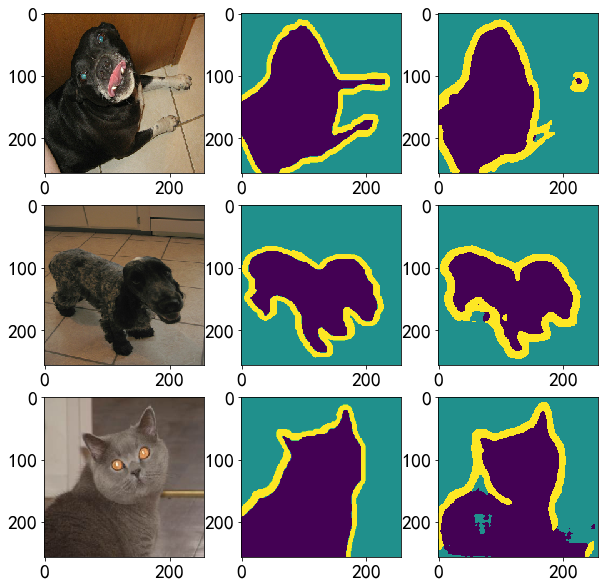

In [68]:
num = 3
for image,mask in data_test.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask,axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    
    plt.figure(figsize=(10,10))
    for i in range(num):
        plt.subplot(num,3,i*num+1)
        plt.imshow((image[i].numpy()+1)/2)
        plt.subplot(num,3,i*num+2)
        plt.imshow(tf.squeeze(mask[i].numpy()))
        plt.subplot(num,3,i*num+3)
        plt.imshow(tf.squeeze(pred_mask[i].numpy()))

### 8.2额外数据集测试

In [27]:
# 将数据包从OBS下载到ModelArts
print('输入数据路径（例：obs://桶名/目录/test.zip）')
src = input('数据路径：')
moxing.file.copy_parallel(src_url=src, dst_url='test.zip') # 下载数据

# 解压缩数据包
os.system('unzip test.zip')

输入数据路径（例：obs://桶名/目录/test.zip）
数据路径：obs://fxy4/Unet/test.zip


0

In [28]:
# 读取所有图片路径
test_imgs = glob.glob(r"imgs/*.jpg")
test_imgs.sort()
test_imgs[:5],len(test_imgs)

(['imgs/black-white-kittens2.jpg',
  'imgs/black_kitten.jpg',
  'imgs/black_kitten_star.jpg',
  'imgs/cat-jumping-running-grass.jpg',
  'imgs/cat_bed.jpg'],
 16)

In [29]:
# 读取所有图片路径
test_anno = glob.glob(r"gt/*.png")
test_anno.sort()
test_anno[:5],len(test_anno)

(['gt/black-white-kittens2.png',
  'gt/black_kitten.png',
  'gt/black_kitten_star.png',
  'gt/cat-jumping-running-grass.png',
  'gt/cat_bed.png'],
 16)

In [30]:
dataset_demo = tf.data.Dataset.from_tensor_slices((test_imgs,test_anno))

In [31]:
# 加载测试集函数
def load_images_demo(input_images_path, input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    
    input_image = tf.image.resize(input_image,(256,256))
    input_anno = tf.image.resize(input_anno,(256,256))
    
    input_image = tf.cast(input_image,tf.float32)
    input_image = input_image/127.5 - 1
    
    return input_image,input_anno

In [32]:
data_test_demo = dataset_demo.map(load_images_demo,num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_test_demo = data_test_demo.batch(BATCH_SIZE)

In [ ]:
# for image,mask in data_test_demo:
plt.figure(figsize=(15,60))
for images,mask in data_test_demo:
    pred_mask = model.predict(images)
    pred_mask = tf.argmax(pred_mask,axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]

    for i in range(len(images)):
        plt.subplot(len(images),3,i*num+1)
        plt.imshow((images[i].numpy()+1)/2)
        plt.axis('off')
        plt.title('origin',fontsize=15)
        plt.subplot(len(images),3,i*num+2)
        plt.imshow(tf.squeeze(mask[i].numpy()))
        plt.axis('off')
        plt.title('mask',fontsize=15)
        plt.subplot(len(images),3,i*num+3)
        plt.imshow(tf.squeeze(pred_mask[i].numpy()))
        plt.axis('off')
        plt.title('predict',fontsize=15)